In [1]:
#!/usr/bin/env python3

import sys
import pandas as pd
import datetime
import requests
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit
from time import sleep

# from datetime import datetime
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)

In [2]:
def read_data(devid, acc_token, address, start_time, end_time, descriptors):


    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    if r2:
        #print('request completed')
        df = pd.DataFrame([])
#         print(r2.keys())
        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            df = pd.concat([df, df1], axis=1)

        
        if df.empty == False:

            df.reset_index(drop=False, inplace=True)
            df = df.sort_values(by=['ts'])
            df.reset_index(drop=True, inplace=True)
            df.set_index('ts', inplace=True, drop=True)
            for col in df.columns:
                df[col] = df[col].astype('float')

            df = df.groupby(df.index).max()
            
        else:
            df = pd.DataFrame([])
    else:
        df = pd.DataFrame([])
#         print('Empty json!')
    return df

def request_data(start_time,end_time,devid,acc_token,address,descriptors):
    df = pd.DataFrame([])
    svec = np.arange(int(start_time[0]),int(end_time[0]),3600000)
    hour = 1
    for st in svec:
        print(hour)
        hour = hour+1
        en = st+3600000-1

        if int(end_time[0])-en<=0: en = int(end_time[0])
    #         print('start and end of iteration:',st,en)

        tmp = read_data(devid, acc_token, address, str(st), str(en), descriptors)
        if not tmp.empty:
            df = pd.concat([df,tmp])
        sleep(1)

    df['ts'] = pd.to_datetime(df.index,utc=True, unit='ms')
    df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

    df.set_index('ts',inplace=True, drop=True)
    return df




In [8]:
tmzn = 'Europe/Athens'


start_time = 1614722400000
end_time = 1614808800000

address = "http://meazonthings.westeurope.cloudapp.azure.com:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()

acc_token = 'Bearer' + ' ' + r['token']



In [9]:
# download full house data

devid = '8a65b210-609b-11eb-bf57-2df896770934' # 045
descriptors = 'pwrA,cnrgA,pwrB,cnrgB,pwrC,cnrgC'


r = requests.post(address + "/api/auth/login",
                  json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()

# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']


timediff = int(end_time)-int(start_time)

# if difference between end and start time is greater than 15 minutes, split data 

summary = pd.DataFrame([])
svec = np.arange(int(start_time),int(end_time),3000000)
hour = 1
for st in svec:
    print(hour)
    hour = hour+1
    en = st+3000000-1

    if int(end_time)-en<=0: en = int(end_time)
#         print('start and end of iteration:',st,en)

    tmp = read_data(devid, acc_token, address, str(st), str(en), descriptors)
    if not tmp.empty:
        summary = pd.concat([summary,tmp])




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [10]:
# summary = summary[['pwrA','cnrgA']]
summary['ts'] = pd.to_datetime(summary.index,utc=True, unit='ms')
summary['ts'] = summary['ts'].dt.tz_convert('Europe/Athens')

summary.set_index('ts',inplace=True, drop=True)
# summary = summary.resample('1S').mean()

summary.head()

,pwrA,cnrgA,pwrB,cnrgB,pwrC,cnrgC
ts,,,,,,
2021-03-03 00:00:55.513000+02:00,178.753235,1291182.0,-0.358223,713007.0,-0.044778,62939.0
2021-03-03 00:01:55.513000+02:00,191.649246,1291185.0,-0.089556,713007.0,-0.134334,62939.0
2021-03-03 00:02:55.513000+02:00,179.156235,1291188.0,-0.582112,713007.0,-0.582112,62939.0
2021-03-03 00:03:55.513000+02:00,221.874313,1291191.0,-0.492556,713007.0,0.179111,62939.0
2021-03-03 00:04:55.513000+02:00,220.351868,1291195.0,-0.358223,713007.0,-0.179111,62939.0


In [11]:
summary = summary.resample('1T').max()
summary.head()

,pwrA,cnrgA,pwrB,cnrgB,pwrC,cnrgC
ts,,,,,,
2021-03-03 00:00:00+02:00,178.753235,1291182.0,-0.358223,713007.0,-0.044778,62939.0
2021-03-03 00:01:00+02:00,191.649246,1291185.0,-0.089556,713007.0,-0.134334,62939.0
2021-03-03 00:02:00+02:00,179.156235,1291188.0,-0.582112,713007.0,-0.582112,62939.0
2021-03-03 00:03:00+02:00,221.874313,1291191.0,-0.492556,713007.0,0.179111,62939.0
2021-03-03 00:04:00+02:00,220.351868,1291195.0,-0.358223,713007.0,-0.179111,62939.0


In [113]:
# summary = summary.resample('1T').max()
# summary.head()

In [12]:
apps = pd.read_csv('3_3_2021.csv')
apps.rename(columns={'Unnamed: 0':'ts'},inplace=True)
apps.set_index('ts',inplace=True, drop=True)
apps['ts'] = pd.to_datetime(apps.index,utc=True)
apps['ts'] = apps['ts'].dt.tz_convert('Europe/Athens')
apps.set_index('ts',inplace=True, drop=True)
apps = apps.resample('1T').max()

apps.head()


,appl,state,end,dif
ts,,,,
2021-03-03 00:30:00+02:00,fridge,1.0,0.0,0.0
2021-03-03 00:31:00+02:00,NaN,NaN,NaN,NaN
2021-03-03 00:32:00+02:00,NaN,NaN,NaN,NaN
2021-03-03 00:33:00+02:00,NaN,NaN,NaN,NaN
2021-03-03 00:34:00+02:00,NaN,NaN,NaN,NaN


In [13]:
summary = pd.concat([summary,apps],axis=1)
summary.head()

,pwrA,cnrgA,pwrB,cnrgB,pwrC,cnrgC,appl,state,end,dif
ts,,,,,,,,,,
2021-03-03 00:00:00+02:00,178.753235,1291182.0,-0.358223,713007.0,-0.044778,62939.0,NaN,NaN,NaN,NaN
2021-03-03 00:01:00+02:00,191.649246,1291185.0,-0.089556,713007.0,-0.134334,62939.0,NaN,NaN,NaN,NaN
2021-03-03 00:02:00+02:00,179.156235,1291188.0,-0.582112,713007.0,-0.582112,62939.0,NaN,NaN,NaN,NaN
2021-03-03 00:03:00+02:00,221.874313,1291191.0,-0.492556,713007.0,0.179111,62939.0,NaN,NaN,NaN,NaN
2021-03-03 00:04:00+02:00,220.351868,1291195.0,-0.358223,713007.0,-0.179111,62939.0,NaN,NaN,NaN,NaN


In [14]:
summary=summary.dropna(subset=['pwrA'])
summary.head()

,pwrA,cnrgA,pwrB,cnrgB,pwrC,cnrgC,appl,state,end,dif
ts,,,,,,,,,,
2021-03-03 00:00:00+02:00,178.753235,1291182.0,-0.358223,713007.0,-0.044778,62939.0,NaN,NaN,NaN,NaN
2021-03-03 00:01:00+02:00,191.649246,1291185.0,-0.089556,713007.0,-0.134334,62939.0,NaN,NaN,NaN,NaN
2021-03-03 00:02:00+02:00,179.156235,1291188.0,-0.582112,713007.0,-0.582112,62939.0,NaN,NaN,NaN,NaN
2021-03-03 00:03:00+02:00,221.874313,1291191.0,-0.492556,713007.0,0.179111,62939.0,NaN,NaN,NaN,NaN
2021-03-03 00:04:00+02:00,220.351868,1291195.0,-0.358223,713007.0,-0.179111,62939.0,NaN,NaN,NaN,NaN


In [15]:
appls = summary['appl'].unique()
appls=list(appls[1:])
appls

['fridge',
 'radiator',
 'aerothermo',
 'microwave',
 'coffeemaker',
 'dishwasher',
 'water heater']

In [17]:
summary['appl'].replace({'aerothermo':'fan heater'},inplace=True)
appls = summary['appl'].unique()
appls=list(appls[1:])
appls

['fridge',
 'radiator',
 'fan heater',
 'microwave',
 'coffeemaker',
 'dishwasher',
 'water heater']

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


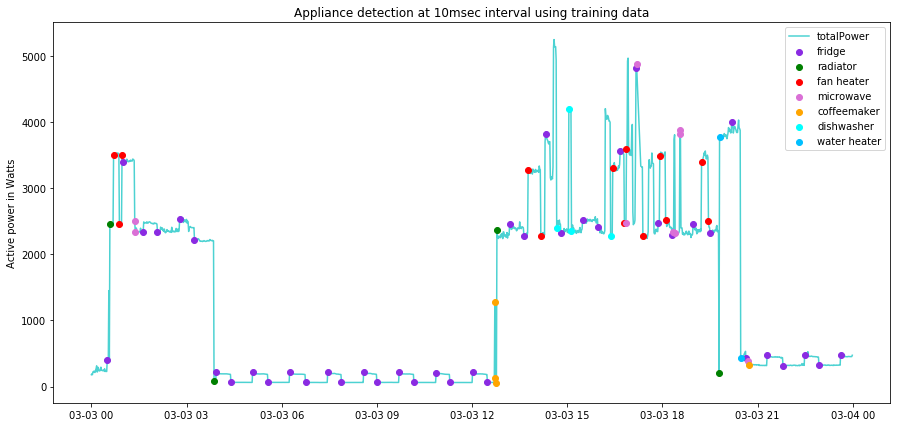

In [18]:
phases = ['A']
for j in range(0,1):
    ndf = summary.copy()

    pwr = 'pwrA'
    fig = plt.figure(figsize=[15,7])
    plt.plot(ndf.index,ndf[pwr],'c',alpha=0.7)#,df2.index,df2['rpwrB'])
    colors = ['blueviolet','green','red','orchid','orange','aqua','deepskyblue']

    for i in range(0,len(appls)):
        cl = ndf['appl']==appls[i]
        plt.scatter(ndf.index[cl], ndf[pwr][cl], color=colors[i],zorder=10)

    plt.legend(['totalPower']+appls)
    plt.title('Appliance detection at 10msec interval using training data')
    plt.ylabel('Active power in Watts')
    



/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-di

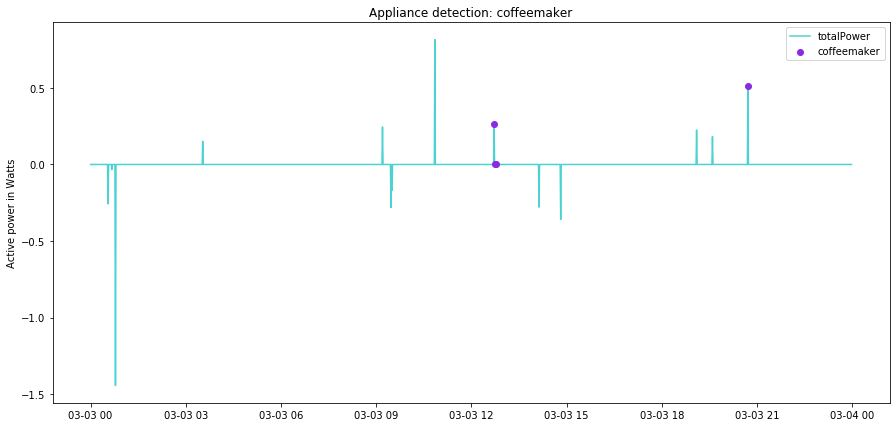

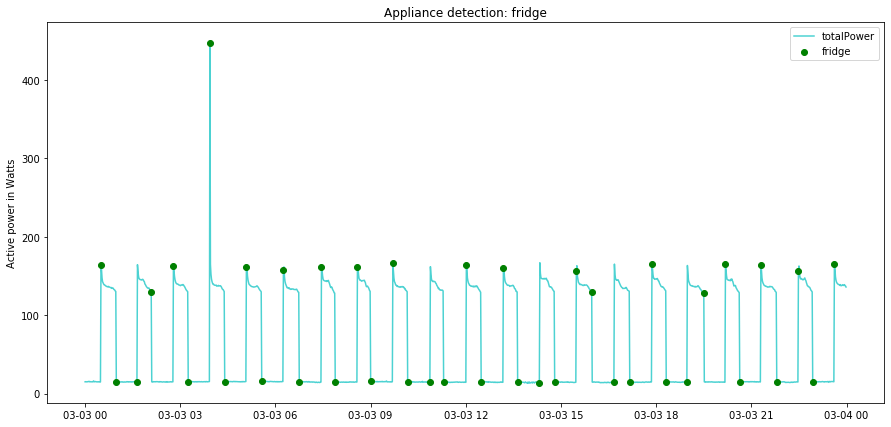

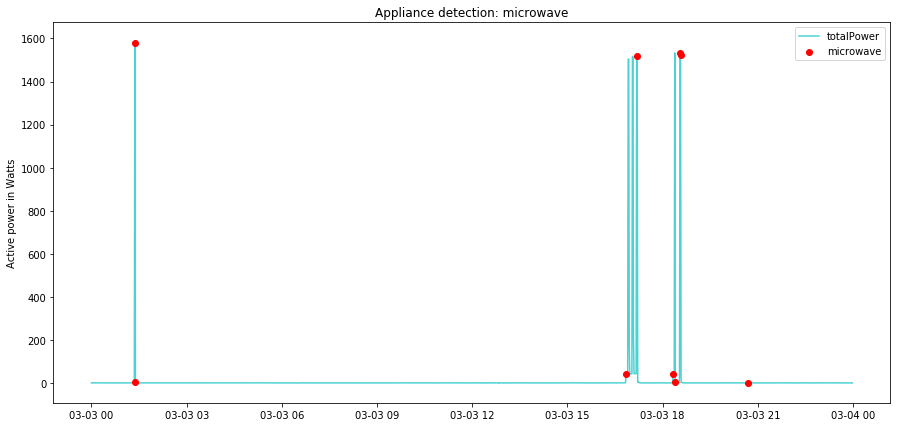

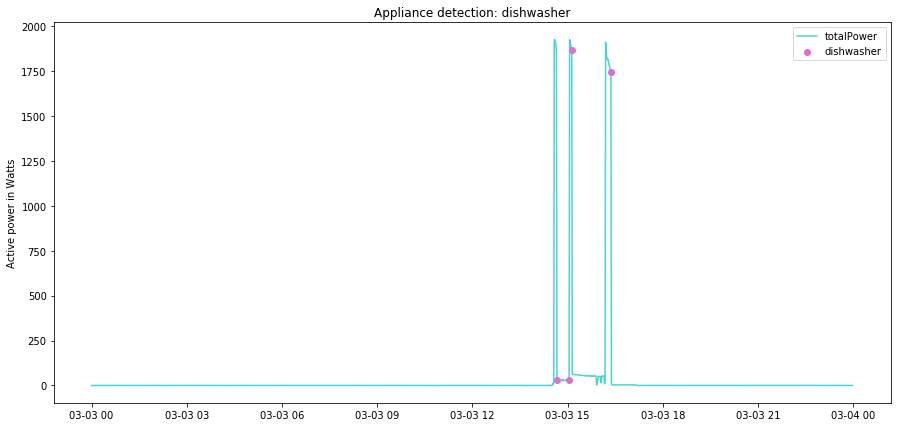

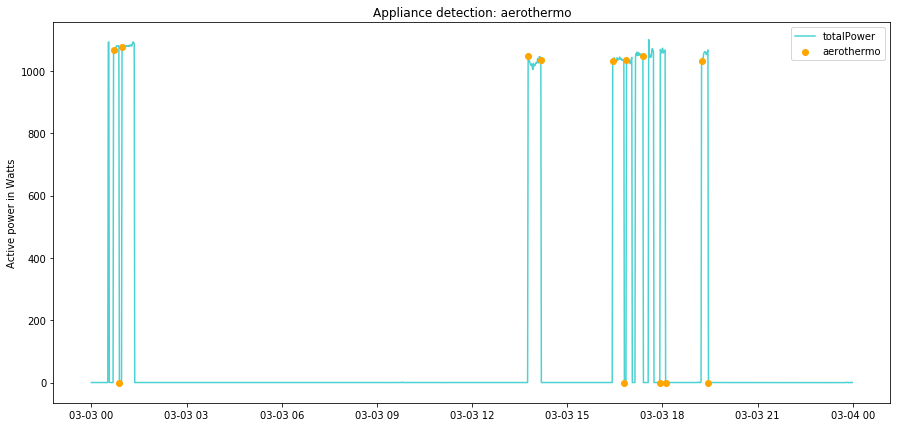

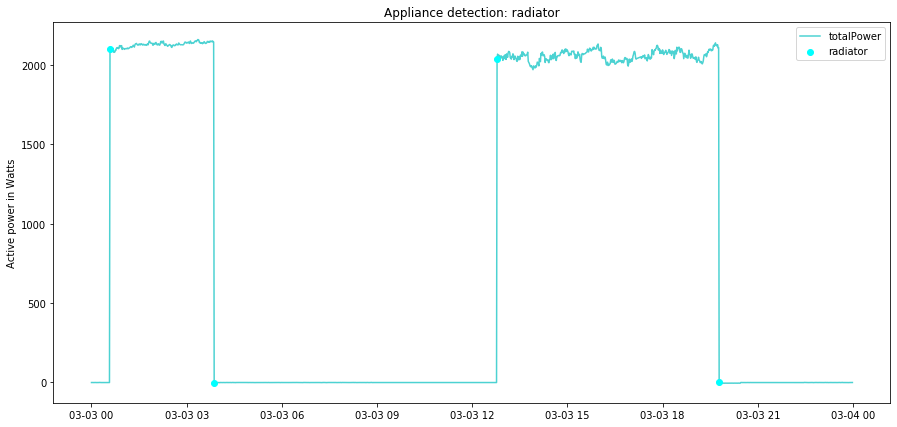

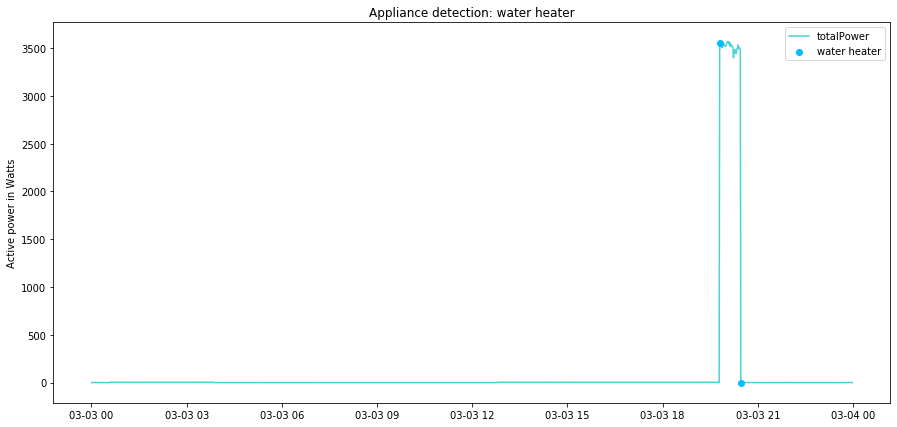

In [120]:

# 4,14,13,2,8,rad,water
# download full house data
devs=['coffeemaker','fridge','microwave','dishwasher','aerothermo','radiator','water heater']
devids = ['df1bd470-633d-11eb-bf57-2df896770934','7a8d0260-6133-11eb-bf57-2df896770934','5d41c6b0-6d5d-11eb-bf57-2df896770934','5d2eb3e0-6d5d-11eb-bf57-2df896770934','e5ee01f0-609b-11eb-bf57-2df896770934','8a65b210-609b-11eb-bf57-2df896770934','8a65b210-609b-11eb-bf57-2df896770934'] # 014


for i in range(0,len(devs)):
    devid=devids[i]
    
    if i==5:
        descriptors = 'pwrB'
    elif i==6:
        descriptors = 'pwrC'
    else:
        descriptors = 'pwrA'
    
    r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()

    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']


    timediff = int(end_time)-int(start_time)

    # if difference between end and start time is greater than 15 minutes, split data 

    summary = pd.DataFrame([])
    svec = np.arange(int(start_time),int(end_time),3000000)
    hour = 1
    for st in svec:
    #     print(hour)
        hour = hour+1
        en = st+3000000-1

        if int(end_time)-en<=0: en = int(end_time)
    #         print('start and end of iteration:',st,en)

        tmp = read_data(devid, acc_token, address, str(st), str(en), descriptors)
        if not tmp.empty:
            summary = pd.concat([summary,tmp])


    summary['ts'] = pd.to_datetime(summary.index,utc=True, unit='ms')
    summary['ts'] = summary['ts'].dt.tz_convert('Europe/Athens')

    summary.set_index('ts',inplace=True, drop=True)

    summary = summary.resample('1T').mean()
    summary = pd.concat([summary,apps],axis=1)
    summary.loc[summary['appl']!=devs[i],'appl']=np.nan
    summary.loc[summary['appl']!=devs[i],'end']=np.nan
    summary=summary.dropna(subset=[descriptors])
#     print(summary.head(10))
    appls = summary['appl'].unique()
    
    ###########################
    tmp = summary.loc[summary['end']==1]
    lastind=tmp.index[-1]
    
    summary.loc[summary.index>lastind,'end']=np.nan
    summary['onoff']=np.nan
    activ=0
    for k in range(0,summary.shape[0]):
        if summary['end'].iloc[k]==0:
            activ=1
        
        if activ==1:
            summary['onoff'].iloc[k]=1
        if summary['end'].iloc[k]==1:
            activ=0
    ###########################
    #print(summary.loc[summary['onoff']==1])
    # Plot
    ndf = summary.copy()

    pwr = descriptors
    fig = plt.figure(figsize=[15,7])
    plt.plot(ndf.index,ndf[pwr],'c',alpha=0.7)#,df2.index,df2['rpwrB'])
    colors = ['blueviolet','green','red','orchid','orange','aqua','deepskyblue']

    for j in range(0,len(appls)):
#         cl = ndf['onoff']==1
        cl = ndf['appl']==appls[j]
        plt.scatter(ndf.index[cl], ndf[pwr][cl], color=colors[i],zorder=10)
    plt.legend(['totalPower',devs[i]])
    plt.title('Appliance detection: '+devs[i])
    plt.ylabel('Active power in Watts')